In [2]:
import lightgbm as lgbm
from hyperopt import hp, tpe, Trials

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils.preprocessing import preprocessing 
from utils.utils import feature_importances,initial_hyperparam_search,cast_params_to_proper_types,lgb_f1_score,feature_imp_lgbm

In [4]:
prepos= preprocessing()
df_credit_application = prepos.read_data("credit_applications.csv")
df_customers = prepos.read_data("customers.csv")
df_customers.drop("Unnamed: 0",axis=1,inplace=True)
df_credit_application.drop("Unnamed: 0",axis=1,inplace=True)

In [5]:
df_complete_data = df_customers.merge(df_credit_application,how="inner",on=["client_nr","yearmonth"])
print(df_complete_data.shape)

(29996, 12)


##### EDA And feature importances

In [6]:
df_complete_data.describe()

,client_nr,yearmonth,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,CRG,credit_application,nr_credit_applications
count,29996.000000,29996.000000,29996.000000,29996.000000,2.999600e+04,29996.000000,2.999600e+04,2.999600e+04,2.999600e+04,24459.000000,29996.000000,29996.000000
mean,481.560775,201493.675157,166.427957,75.785571,1.121290e+07,90.642386,1.126906e+07,-5.523773e+06,3.752693e+06,3.251850,0.067509,0.087078
std,281.317753,77.361645,220.947519,60.063496,1.617596e+07,192.244770,1.624998e+07,1.357517e+07,1.616937e+07,1.889136,0.250906,0.364473
min,1.000000,201401.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,-3.467127e+08,-2.485206e+08,1.000000,0.000000,0.000000
25%,237.000000,201409.000000,76.000000,38.000000,3.072750e+06,33.000000,3.148068e+06,-7.895864e+06,-1.868002e+06,2.000000,0.000000,0.000000
50%,479.000000,201505.000000,129.000000,66.000000,6.822769e+06,56.000000,6.934694e+06,-2.957198e+06,1.040998e+06,3.000000,0.000000,0.000000
75%,721.000000,201601.000000,205.000000,101.000000,1.386656e+07,102.000000,1.394257e+07,1.690275e+04,5.806224e+06,4.000000,0.000000,0.000000
max,1000.000000,201608.000000,6341.000000,1590.000000,7.980480e+08,6325.000000,8.775321e+08,2.109783e+08,3.722319e+08,7.000000,1.000000,7.000000


<Axes: xlabel='credit_application', ylabel='count'>

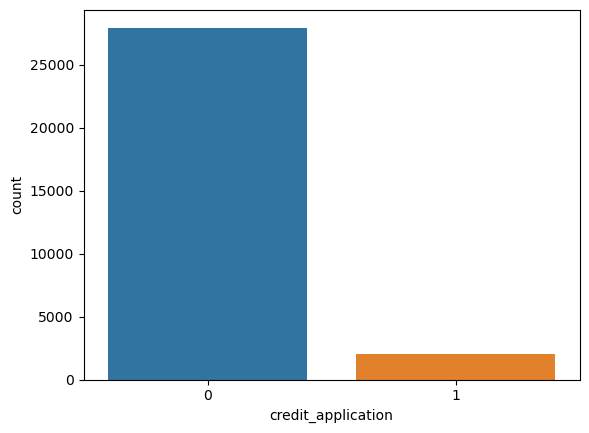

In [7]:
sns.countplot(x=df_complete_data["credit_application"])

# 0    27971
# 1     2025

In [8]:
prepos.missing_values_intable(df_complete_data)

,Missing Values,Percentage of missing values
client_nr,0,0.000000
yearmonth,0,0.000000
total_nr_trx,0,0.000000
nr_debit_trx,0,0.000000
volume_debit_trx,0,0.000000
nr_credit_trx,0,0.000000
volume_credit_trx,0,0.000000
min_balance,0,0.000000
max_balance,0,0.000000
CRG,5537,18.459128


In [9]:
# plt.rcParams["figure.figsize"] = [5,5]  #set the graph to a smaller size 
df_complete_data["debit_credit_ratio"]=df_complete_data["volume_debit_trx"]/df_complete_data["volume_credit_trx"]

In [10]:
df_complete_data["debit_credit_ratio"] = np.where(df_complete_data["debit_credit_ratio"]==np.inf,df_complete_data["volume_debit_trx"],df_complete_data["debit_credit_ratio"])

In [11]:
corl= df_complete_data.corr()
corl["credit_application"].sort_values(ascending=False)

credit_application        1.000000
nr_credit_applications    0.887960
CRG                       0.104958
nr_debit_trx              0.030467
client_nr                 0.020659
volume_credit_trx         0.013168
volume_debit_trx          0.008674
total_nr_trx             -0.001848
debit_credit_ratio       -0.002477
yearmonth                -0.011546
nr_credit_trx            -0.011643
max_balance              -0.043633
min_balance              -0.082577
Name: credit_application, dtype: float64

In [12]:
# fimp=feature_importances()
# X_train_feature_selection, accepted_columns,assoc_result,disallowed_columns = fimp.filter_out_features_based_on_statistical_approach(df_complete_data,[],"credit_application")
# print(accepted_columns)
# print(assoc_result["credit_application"].sort_values(ascending=False))

df_complete_data.drop("nr_credit_applications",axis=1,inplace=True)
fimp=feature_importances()
X_train_feature_selection, accepted_columns,assoc_result,disallowed_columns = fimp.filter_out_features_based_on_statistical_approach(df_complete_data,[],"credit_application")
print(accepted_columns)
print(assoc_result["credit_application"].sort_values(ascending=False))

Removing columns: []
['min_balance', 'CRG', 'credit_application']
credit_application    1.00
CRG                   0.13
min_balance           0.08
max_balance           0.04
nr_debit_trx          0.03
client_nr             0.02
yearmonth             0.01
volume_debit_trx      0.01
nr_credit_trx         0.01
volume_credit_trx     0.01
total_nr_trx          0.00
debit_credit_ratio    0.00
Name: credit_application, dtype: float64


For a Time being delete rows where CRG is not present

In [13]:
df_complete_data[df_complete_data["CRG"].isna()]["credit_application"].value_counts()
# 0    5395
# 1     142

0    5395
1     142
Name: credit_application, dtype: int64

In [14]:
df_complete_data = df_complete_data[~df_complete_data["CRG"].isna()]

In [15]:
df_complete_data.shape

(24459, 12)

#### To do : Missing value treatment for CRG

In [16]:
df_complete_data.groupby(["client_nr","yearmonth","CRG"])["total_nr_trx"].count().reset_index()

,client_nr,yearmonth,CRG,total_nr_trx
0,1,201401,1.0,1
1,1,201402,1.0,1
2,1,201403,1.0,1
3,1,201404,1.0,1
4,1,201405,1.0,1
...,...,...,...,...
24454,988,201604,3.0,1
24455,988,201605,3.0,1
24456,988,201606,3.0,1
24457,988,201607,3.0,1


###### New features ideas
Calculate how many times client has applied for credit in the past for each month

In [17]:
def calculate_nr_credit_in_past(current_index):
#     print(current_index)
    client_nr = df_complete_data.loc[[current_index]]["client_nr"].values[0]
    tmp_sum = df_complete_data[(df_complete_data["client_nr"]==client_nr) & (df_complete_data.index <current_index)]["credit_application"].sum()
    tmp_cnt = df_complete_data[(df_complete_data["client_nr"]==client_nr) & (df_complete_data.index <current_index)]["credit_application"].count()
    if(tmp_cnt==0):
        return 0
    else:
        return tmp_sum/tmp_cnt

In [18]:
df_complete_data.to_csv("test_the feature.csv")

In [19]:
df_complete_data["credit_applied_before_ratio"]= df_complete_data.index.map(calculate_nr_credit_in_past)

#### Split data strategy

As part of train/test data split, 20% of data will be reserved as test data and will not seen by any model.
That amounts to approximately = 6 months worth of data.
Instead of splitting train/test data randomly, I decided to leave last 6 month data as test data set i.e. March 2016 to August 2016

In [20]:
X_test = df_complete_data[df_complete_data["yearmonth"].isin([201608,201607,201606,201605,201604,201603])].copy()
y_test = X_test["credit_application"]

X_train_org = df_complete_data[~df_complete_data["yearmonth"].isin([201608,201607,201606,201605,201604,201603])].copy()
y_train_org = X_train_org["credit_application"]

X_train,X_val,y_train,y_val=train_test_split(X_train_org,X_train_org["credit_application"],test_size=0.2,random_state=42,stratify=X_train_org["credit_application"])

X_test.drop(["credit_application","client_nr"],axis=1,inplace=True)
X_train_org.drop(["credit_application","client_nr"],axis=1,inplace=True)
X_train.drop(["credit_application","client_nr"],axis=1,inplace=True)
X_val.drop(["credit_application","client_nr"],axis=1,inplace=True)


# X_test.drop(["credit_application","client_nr","nr_credit_applications"],axis=1,inplace=True)
# X_train_org.drop(["credit_application","client_nr","nr_credit_applications"],axis=1,inplace=True)
# X_train.drop(["credit_application","client_nr","nr_credit_applications"],axis=1,inplace=True)
# X_val.drop(["credit_application","client_nr","nr_credit_applications"],axis=1,inplace=True)

##### 2. Using Lightgbm feature importance

In [54]:
[x for x in range(10, 500,30)]

[10,
 40,
 70,
 100,
 130,
 160,
 190,
 220,
 250,
 280,
 310,
 340,
 370,
 400,
 430,
 460,
 490]

In [69]:
from lightgbm import plot_importance
from sklearn.model_selection import GridSearchCV
# params_scope = {
#     'learning_rate': hp.uniform('learning_rate', 0.001, 0.1),
#     'num_leaves': hp.quniform('num_leaves', 2, 15, 1),
#     'n_estimators': hp.quniform('n_estimators', 10, 500, 10),
#     'scale_pos_weight': hp.choice('scale_pos_weight',[90]),
#     'reg_lambda ': hp.uniform('reg_lambda', 10.00, 100.0),
#     'pos_bagging_fraction': hp.uniform('pos_bagging_fraction', 0.0, 1.0),
#     'max_bin': hp.quniform('max_bin', 16, 256, 16)
#                             }


params_scope = {
#                 'learning_rate': [x/1000 for x in range(1, 110,10)],
                'n_estimators': [x for x in range(10, 500,50)],
               'num_leaves': [x for x in range(2, 15,2)],
               'scale_pos_weight':[x for x in range(85, 100,5)],
               'objective': ['binary'],
#                'reg_lambda ': [x for x in range(10, 100,10)],
               }

In [70]:
import lightgbm as lgb
model = lgb.LGBMClassifier(**params_scope)


In [71]:
grid = GridSearchCV(model, param_grid=params_scope, verbose=1, cv=3, n_jobs=-1)
# Run the grid
grid.fit(X_train,y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)


Fitting 3 folds for each of 210 candidates, totalling 630 fits
{'n_estimators': 460, 'num_leaves': 14, 'objective': 'binary', 'scale_pos_weight': 85}
0.6769290516820478


In [74]:
model = grid.best_estimator_
feature_imp_df = pd.DataFrame(data={'feature_name':model.feature_name_,
                   'feature_importance':model.feature_importances_},
            
            )
feature_imp_df.sort_values(by="feature_importance",ascending=False,inplace=True)

In [75]:
# model,initial_params = feature_imp_lgbm(X_train,y_train,X_val,y_val,params_scope)
# feature_imp_df = pd.DataFrame(data={'feature_name':model.feature_name_,
#                    'feature_importance':model.feature_importances_},
            
#             )
# feature_imp_df.sort_values(by="feature_importance",ascending=False,inplace=True)

In [76]:
# initial_params

In [77]:
feature_imp_df

,feature_name,feature_importance
9,debit_credit_ratio,692
6,min_balance,660
2,nr_debit_trx,636
7,max_balance,634
4,nr_credit_trx,623
5,volume_credit_trx,554
3,volume_debit_trx,496
1,total_nr_trx,492
0,yearmonth,490
10,credit_applied_before_ratio,483


In [78]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,f1_score,confusion_matrix,precision_score,recall_score,roc_curve

In [79]:
kfolds = StratifiedKFold(5)
current_f1_scores=[]
roc_auc_scores_val=[]
precision_score_val=[]
recall_score_val=[]
fpr_scores=[]
tpr_scores=[]
mean_roc_auc_scores_val = []
mean_precision_scores_val = []
mean_recall_scores_val = []
mean_f1_scores_val = []

In [80]:
for train_idx ,val_index in kfolds.split(X_train_org,y_train_org):
#     model = lgb.LGBMClassifier(
#                 verbose=-1,
#                 objective='binary',
#                 **initial_params
#             )
    model.fit(
                X_train_org.iloc[train_idx],
                y_train_org.iloc[train_idx],
#                 eval_set=[(X_train.iloc[val_index], y_train.iloc[val_index])],
                eval_metric=lgb_f1_score
            )
    y_pred=np.where(model.predict_proba(X_train_org.iloc[val_index])[:,1] >0.4,1,0)
#     y_pred=model.predict(X_train_org.iloc[val_index])
    current_f1_scores.append(f1_score(y_train_org.iloc[val_index], y_pred))
    tn, fp, fn, tp = confusion_matrix(y_train_org.iloc[val_index],y_pred).ravel()
    print(confusion_matrix(y_train_org.iloc[val_index],y_pred))
    roc_auc_scores_val.append(roc_auc_score(y_true=y_train_org.iloc[val_index], y_score=y_pred))
    precision_score_val.append(precision_score(y_true=y_train_org.iloc[val_index],y_pred=y_pred))
    recall_score_val.append(recall_score(y_true=y_train_org.iloc[val_index],y_pred=y_pred))
    fpr_val, tpr_val, _ = roc_curve(y_true=y_train_org.iloc[val_index], y_score=y_pred)
    fpr_scores.append(fpr_val)
    tpr_scores.append(tpr_val)
    
    

[[2045 1623]
 [ 123  189]]
[[1769 1898]
 [ 136  176]]
[[1733 1934]
 [ 139  173]]
[[1563 2104]
 [ 123  189]]
[[1773 1894]
 [ 122  190]]


In [81]:
def plot_roc(fpr,tpr,roc_auc,color_ip):
#     fpr,tpr,threshold=roc_curve(y_test,probs)
#     roc_auc=auc(fpr,tpr)
    print('ROC AUC=%0.2f'%roc_auc)
    plt.plot(fpr,tpr,label='AUC=%0.2f'%roc_auc,color=color_ip)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'b--')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True) 
#     plt.show()

ROC AUC=0.58
ROC AUC=0.52
ROC AUC=0.51
ROC AUC=0.52
ROC AUC=0.55
Mean ROC AUC score on validation data =0.54


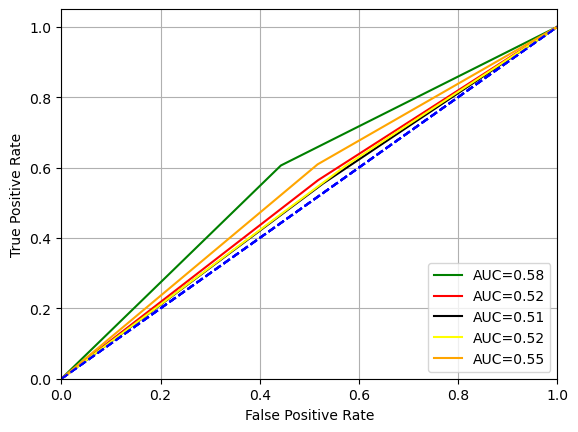

In [82]:
color_list=["green","red","black","yellow","orange"]
for fpr_val,tpr_val,roc_auc_score,color in zip(fpr_scores,tpr_scores,roc_auc_scores_val,color_list):
    plot_roc(fpr_val,tpr_val,roc_auc_score,color)
    
    
print('Mean ROC AUC score on validation data =%0.2f'%np.mean(roc_auc_scores_val))

In [83]:
def print_metrics(f1_scores,recall_scores,precision_scores,dataset="validation"):
    print("F1 scores on "+ dataset+" data:")
    print(f1_scores)
    print("-----------------------------------------------------")
    print("Recall scores on "+ dataset+" data:")
    print(recall_scores)
    print("-----------------------------------------------------")
    print("Mean f1 score on "+ dataset+" data:")
    print(np.mean(f1_scores))

    print("-----------------------------------------------------")
    print("Mean recall score on "+ dataset+" data:")
    print(np.mean(recall_scores))

    print("-----------------------------------------------------")
    print("Mean precision score on "+ dataset+" data:")
    print(np.mean(precision_scores))

In [84]:
print_metrics(current_f1_scores,recall_score_val,precision_score_val,"validation")

F1 scores on validation data:
[0.17796610169491525, 0.14752724224643757, 0.1430343116990492, 0.14510556621881, 0.15859766277128548]
-----------------------------------------------------
Recall scores on validation data:
[0.6057692307692307, 0.5641025641025641, 0.5544871794871795, 0.6057692307692307, 0.6089743589743589]
-----------------------------------------------------
Mean f1 score on validation data:
0.1544461769260995
-----------------------------------------------------
Mean recall score on validation data:
0.5878205128205127
-----------------------------------------------------
Mean precision score on validation data:
0.08897353344533346


In [87]:
X_test=X_test[X_train.columns]

In [88]:

y_test_pred=np.where(model.predict_proba(X_test)[:,1] >0.4,1,0)

print(confusion_matrix(y_test,y_test_pred))
print("F1 score on Test data:")
print(f1_score(y_test,y_test_pred))
print("-----------------------------------------------------")
print("Recall score on Test data:")
print(recall_score(y_test,y_test_pred))
print("-----------------------------------------------------")
print("Precision score on Test data:")
print(precision_score(y_test,y_test_pred))

[[3289  951]
 [ 196  127]]
F1 score on Test data:
0.1812990720913633
-----------------------------------------------------
Recall score on Test data:
0.3931888544891641
-----------------------------------------------------
Precision score on Test data:
0.11781076066790352


In [89]:
# y_test_pred = model.predict(X_test)
for i in np.arange(0.3,0.65,0.051):
    i=(round(i,2))
    print("---------------THRESHOLD ="+str(i)+" ----------------------")

    y_test_pred=np.where(model.predict_proba(X_test)[:,1] >i,1,0)

    print(confusion_matrix(y_test,y_test_pred))
    print("F1 score on Test data:")
    print(f1_score(y_test,y_test_pred))
    print("-----------------------------------------------------")
    print("Recall score on Test data:")
    print(recall_score(y_test,y_test_pred))
    print("-----------------------------------------------------")
    print("Precision score on Test data:")
    print(precision_score(y_test,y_test_pred))

---------------THRESHOLD =0.3 ----------------------
[[3012 1228]
 [ 171  152]]
F1 score on Test data:
0.178508514386377
-----------------------------------------------------
Recall score on Test data:
0.47058823529411764
-----------------------------------------------------
Precision score on Test data:
0.11014492753623188
---------------THRESHOLD =0.35 ----------------------
[[3160 1080]
 [ 181  142]]
F1 score on Test data:
0.18381877022653723
-----------------------------------------------------
Recall score on Test data:
0.43962848297213625
-----------------------------------------------------
Precision score on Test data:
0.11620294599018004
---------------THRESHOLD =0.4 ----------------------
[[3289  951]
 [ 196  127]]
F1 score on Test data:
0.1812990720913633
-----------------------------------------------------
Recall score on Test data:
0.3931888544891641
-----------------------------------------------------
Precision score on Test data:
0.11781076066790352
---------------THRE

In [90]:
X_test

,yearmonth,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,CRG,debit_credit_ratio,credit_applied_before_ratio
26,201603,60,40,3532728,20,3541991,-9923867,12750606,1.0,0.997385,0.0
27,201604,45,32,819025,13,488143,-10291903,12750426,1.0,1.677838,0.0
28,201605,45,30,999849,15,431060,-10724536,1636168,1.0,2.319512,0.0
29,201606,23,21,250012,2,47701,-10868626,1585224,1.0,5.241232,0.0
30,201607,39,33,578297,6,178219,-11189619,12750338,1.0,3.244867,0.0
...,...,...,...,...,...,...,...,...,...,...,...
29832,201604,99,58,6860742,41,6275498,-61718,792456,3.0,1.093259,0.0
29833,201605,143,99,11295466,44,10125313,-1418357,2846231,3.0,1.115567,0.0
29834,201606,119,79,5869965,40,6567639,-1327262,-143964,3.0,0.893771,0.0
29835,201607,121,80,6632809,41,6077459,-1376355,-266210,3.0,1.091379,0.0


In [92]:
X_test["ground_truth"] = y_test
X_test["pred_lgbm"]=y_test_pred
X_test.to_csv("predictions_on_test_set_lgbm.csv")


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


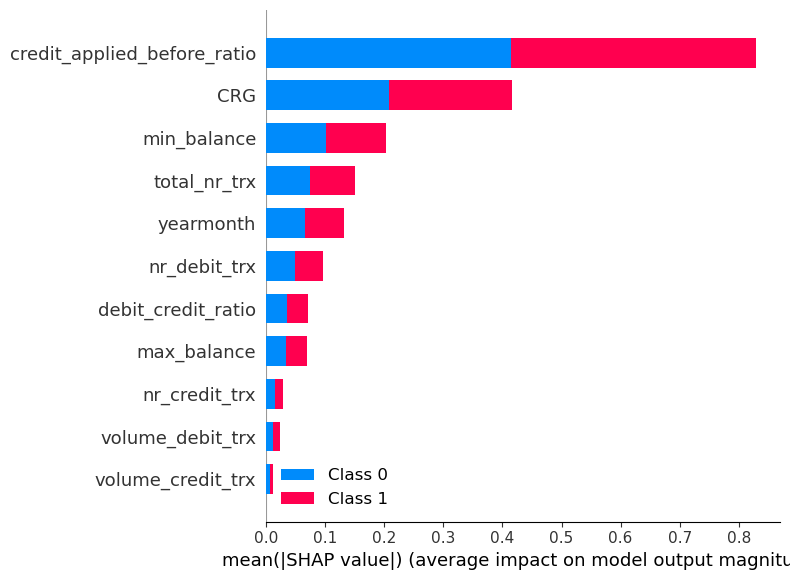

In [91]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val[X_train.columns])
shap.summary_plot(shap_values, X_val[X_train.columns], plot_type="bar")